In [1]:
from apiclient.discovery import build
from apiclient.errors import HttpError
import pprint 
from keras.preprocessing import text, sequence
from keras.models import load_model
import json
import sys
from urllib import *
import argparse
from urllib.parse import urlparse, urlencode, parse_qs
from urllib.request import  urlopen
import pandas as pd 
import numpy as np 

Using TensorFlow backend.
/home/youngroz/anaconda3/envs/tf-keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/youngroz/anaconda3/envs/tf-keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Getting started 

You need the following: 
1. A youtube api client id. Obtain it [here](https://developers.google.com/youtube/registering_an_application). 
2. A trained and saved model 
3. Change client id and model path in code below. 

In [5]:
CLIENT_ID = "REPLACE_WITH_YOUR_API_ID"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=CLIENT_ID)
model = load_model('/PATH/TO/model.h5')
YOUTUBE_COMMENT_URL = 'https://www.googleapis.com/youtube/v3/commentThreads'

# Get comments

In [3]:
def getCommentThreads(videoId, nextPageToken):
    try: 
        results = youtube.commentThreads().list(
            part='snippet', 
            videoId=videoId, 
            maxResults=100, 
            pageToken=nextPageToken,
            textFormat='plainText'
        ).execute()
    except HttpError: 
        results = youtube.commentThreads().list(
            part='snippet', 
            videoId=videoId, 
            maxResults=100, 
            pageToken=nextPageToken,
            textFormat='plainText'
        ).execute()
    return results

def getComments(response):
    # append the correct info to the authors and comments arrays
    for item in response["items"]:
        #print(item)
        
        # parse the response from the API method
        commentList = item["snippet"]["topLevelComment"]
        replyCount = item["snippet"]["totalReplyCount"] 
        #author = commentList["snippet"]["authorDisplayName"]
        text = commentList["snippet"]["textDisplay"]
        authorId = commentList["id"]
        
        # append to appropriate vectors
        comments.append(text)

        
        # if there are replies, we need to grab those too 
        if(replyCount>0):
            results = youtube.comments().list(
                part="snippet",
                parentId=authorId,
                textFormat="plainText",
                maxResults=100
            ).execute()
            for item in results["items"]:
                text = item["snippet"]["textDisplay"]
                comments.append(text) 
                
            nPT = results.get("nextPageToken", False)
            while nPT:
                results = youtube.comments().list(
                    part="snippet",
                    parentId=authorId,
                    maxResults=100,
                    pageToken=nPT,
                    textFormat="plainText"
                ).execute()
            
                for item in results["items"]:
                    text = item["snippet"]["textDisplay"]
                
                    comments.append(text) 
                nPT = results.get("nextPageToken", False)
    return 

def loopToGetAllComments(videoId):    
    response = youtube.commentThreads().list(
        part='snippet,replies', 
        videoId=videoId, 
        maxResults=100, 
        textFormat='plainText'
    ).execute() 
    nextPageToken = response.get("nextPageToken", False)
        
    getComments(response)
    while nextPageToken:
        response = getCommentThreads(videoId, nextPageToken)
        getComments(response)
        nextPageToken = response.get("nextPageToken", False)        
    return

# Pass the loop function your youtube video id

In [4]:
comments=[]
loopToGetAllComments('ezOb9Ii-wM4')

In [6]:
len(comments)

18237

# Generate Predictions

In [11]:
max_features = 30000
maxlen = 100
embed_size = 300

In [12]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(comments))
x_test = tokenizer.texts_to_sequences(comments)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [13]:
y_pred = model.predict(x_test)

In [14]:
df = pd.DataFrame(comments, columns=["comment"])
one_hot = B = np.where(y_pred <= 0.3, 0, 1)
df2 = pd.DataFrame(one_hot, columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
df3 = pd.DataFrame(y_pred, columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
df4 = pd.concat([df, df2], axis=1)
print(df4.shape)
df5 = pd.concat([df, df3], axis=1)
print(df5.shape)

(18237, 7)
(18237, 7)


In [15]:
rowsums=df4.iloc[:,1:].sum(axis=1)
df4['clean']=(rowsums==0)
x=df4.iloc[:,1:].sum()
x

toxic             2251.0
severe_toxic         3.0
obscene           1251.0
threat               2.0
insult             557.0
identity_hate       85.0
clean            15983.0
dtype: float64

# Most likely toxic comment

In [16]:
comment = df5.get_value(df5['toxic'].idxmax(),col="comment")
probability = df5.get_value(df5['toxic'].idxmax(),col="toxic")
print(comment)
print(probability)

Watching his channel makes that pretty evident.
0.99850094


/home/youngroz/anaconda3/envs/tf-keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/youngroz/anaconda3/envs/tf-keras/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


# Generate visual

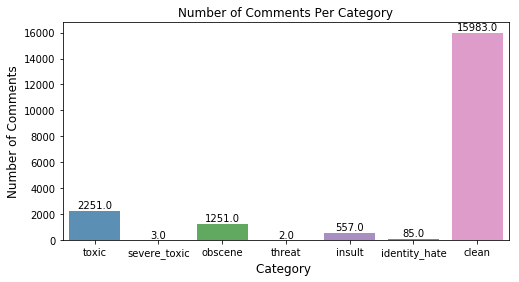

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number of Comments Per Category")
plt.ylabel('Number of Comments', fontsize=12)
plt.xlabel('Category ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()